In [ ]:
!pip install stable-baselines==2.9.0

In [ ]:
import datetime
from time import time

import numpy as np

import torch as T
from torch.autograd import Variable
import torch.nn as nn
from torch.distributions import Categorical
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack, VecNormalize
from stable_baselines.common.running_mean_std import RunningMeanStd

from tqdm import trange
from google.colab import drive
from itertools import count

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
ENV_NAME = 'SpaceInvadersNoFrameskip-v4'
SAVE_PATH = '/content/gdrive/My Drive/RND/'

TOTAL_FRAMES = 5e6    # 5 million frames
ROLLOUT_LENGTH = 128  # transitions in each rollout
NENV = 8              # parallel environments; increase to decorrolate batches
GAMMA = 0.99          # reward discounting coefficient
LAMBDA = 0.95         # GAE discounting coefficient
SEED = 420            # blaze it
MB_SPLIT = 4          # split minibatch into quarters for surrogate calculation
MB_EPOCHS = 4         # epochs per minibatch (4 weight updates on policy per mb)
CLIP = 0.2            # clip the surrogate objective so updates are not too big

STEPS_PER_ROLLOUT = ROLLOUT_LENGTH*NENV
TOTAL_UPDATES = int(TOTAL_FRAMES // STEPS_PER_ROLLOUT)
SPLIT_LEN = int(STEPS_PER_ROLLOUT//MB_SPLIT)
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
print(DEVICE, T.version.cuda)

set_global_seeds(SEED)

# Neural Net Definitions

In [0]:
def conv_size(net, in_shape):
    """ util for calculating flat output shape of a given net """
    x = Variable(T.rand(1, *in_shape))
    o = net(x)
    b = (-1, o.size(1), o.size(2), o.size(3))
    return b, o.data.view(1, -1).size(1)

In [0]:
class ACC(nn.Module):
    """ RND Uses two value heads/critics. One criticises the extrinsic reward
        prediction. The other criticises the intrinsic reward prediction.
    """
    def __init__(self, input_shape, num_actions):
        super().__init__()
        h, w, c = input_shape

        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, 4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(True),
        )
        conv_x, conv_f = conv_size(self.conv, (c,h,w))
        self.conv = nn.Sequential(
            self.conv,
            nn.Flatten(),
            nn.Linear(conv_f, 512),
            nn.ReLU(True)
        )
        self.actor = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, num_actions)
        )
        self.ext_critic = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 1)
        )
        self.int_critic = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        latent = self.conv(x)
        return self.actor(latent), self.ext_critic(latent), self.int_critic(latent)

In [0]:
class RND(nn.Module):
    """ RND sources its intrinsic bonus from the ability of a predictor
        network to estimate the output of a fixed network, where the 
        predictor is only trained by observing the 512-dim output of the
        fixed. The fixed network cannot adapt to the scale of it's inputs,
        so, as mentioned in the paper (2.4), it is crucial to normalize its
        observations/inputs.
    """
    def __init__(self, input_shape):
        super().__init__()
        
        h, w, c = input_shape

        self.fixed_conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, 4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(True)
        )
        _, f = conv_size(self.fixed_conv, (c,h,w))
        self.fixed_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(f, 512),
        )
        self.fixed=nn.Sequential(
            self.fixed_conv, 
            self.fixed_linear
        )
        for param in self.fixed.parameters():
            param.requires_grad = False
            

        self.predictor_conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, 4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(True)
        )
        _, f = conv_size(self.predictor_conv, (c,h,w))
        self.predictor_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(f, 512),
        )
        self.predictor=nn.Sequential(
            self.predictor_conv, 
            self.predictor_linear
        )

    def forward(self, x):
        return self.fixed(x), self.predictor(x)

# Logging utils

In [0]:

class Logger:

    def __init__(self, print_rate=250):
        self.log = {'ep_r':[], 'ep_l':[], 'loss':[], 'pgloss':[], 
                    'vloss':[], 'ent':[], 'int':[], 'cf':[]}
        self.n_ep = 0              # total games/episodes
        self.n_update = 1          # total weight updates
        self.n_frames = 0          # env steps (total from checkpoint)
        self.run_frames = 0        # env steps (for this run)
        self.max_rwd = -np.inf     # max rwd out of all games played
        self.start_time = time()   # time we started *this* run
        self.last_checkpoint = 0   # total_frames at last checkpoint
        self.print_rate = print_rate

    def eta(self):  # hh:mm:ss left to train
        elapsed_time = time() - self.start_time
        frames_left = TOTAL_FRAMES - self.n_frames
        sec_per_frame = elapsed_time / self.n_frames
        sec_left = int(frames_left * sec_per_frame)
        eta_str = str(datetime.timedelta(seconds=sec_left))
        return eta_str

    def fps(self):  # frames per second
        elapsed_time = time() - self.start_time
        fps = int(self.run_frames / elapsed_time)
        return fps

    def sma(self, x):  # simple moving average
        if len(x) == 0: return 'NaN'
        div = 200 if len(x) > 200 else len(x)
        return sum(list(zip(*x[-div:]))[-1])/div

    def print_log(self):
        fps = self.fps()
        eta = self.eta()
        print('-'*10, self.n_update, '/', TOTAL_UPDATES, '-'*10)
        print('Num Games:', self.n_ep)
        print('Num Frames:', self.n_frames)
        print('FPS:', fps)
        print('ETA:', eta)
        print('SMA Length:', self.sma(self.log['ep_l']))
        print('SMA Reward:', self.sma(self.log['ep_r']))
        print('SMA Intrinsic Reward:', self.sma(self.log['int']))
        print('SMA Entropy:', self.sma(self.log['ent']))
        print('SMA Clip %:', self.sma(self.log['cf']))
        print('SMA Loss:', self.sma(self.log['loss']))
        print('SMA PG Loss:', self.sma(self.log['pgloss']))
        print('SMA V Loss:', self.sma(self.log['vloss']))
        print('Max reward:', self.max_rwd)

    def record(self, ep, loss, pgloss, vloss, ent, intr, cf):
        
        self.n_update += 1
        self.n_frames += STEPS_PER_ROLLOUT
        self.run_frames += STEPS_PER_ROLLOUT
        fr = (self.n_frames, self.n_update)

        # stats about finished episodes/games
        for l, r in zip(ep['l'], ep['r']):
            self.log['ep_l'].append(fr+(l,))
            self.log['ep_r'].append(fr+(r,))
            if r > self.max_rwd: self.max_rwd = r
            self.n_ep += 1
             
        # nn training statistics
        self.log['loss'].append(fr+(loss,))
        self.log['pgloss'].append(fr+(pgloss,))
        self.log['vloss'].append(fr+(vloss,))
        self.log['ent'].append(fr+(ent,))
        self.log['int'].append(fr+(intr,))
        self.log['cf'].append(fr+(cf,))
        
        # print log
        if self.n_update % self.print_rate == 0:
            self.print_log()

# Rollout handling

In [0]:
def ob_to_torch(x):
    x = np.moveaxis(x, -1, 1)
    x = T.from_numpy(x).float()
    x = x.to(DEVICE)
    return x

In [0]:
def GAE(rwds, vals, next_val, dones=None):
    """ GAE lambda. vals is full batch, next_val is singular """
    returns = T.empty_like(rwds).to(DEVICE)
    if dones is None: dones = T.ones_like(rwds, dtype=T.bool)
    g = 0
    for i in reversed(range(ROLLOUT_LENGTH)):
        d = rwds[i] + (GAMMA * next_val * ~dones[i]) - vals[i]
        g = d + (GAMMA * LAMBDA * ~dones[i] * g)
        returns[i] = g + vals[i]
        next_val = vals[i]
    adv = returns - vals
    return returns, adv

In [0]:
def rollout_generator(env, acc):
    """ :param acc: ActorCriticCritic policy CNN """

    ob = ob_to_torch(env.reset())
    mb = {'obs':[], 'nobs':[], 'act':[], 'logp':[], 'ext_rwd':[], 
          'done':[], 'int_v':[], 'ext_v':[]}
    ep = {'l':[], 'r':[]}  # len & total reward of done eps 
    nv = {'n_ext_v':0, 'n_int_v':0}  # next values for GAE 
    
    for step in count(1):

        # we compute gradients in the train loop
        with T.no_grad():
            logits, ext_v, int_v = acc(ob)
            dist = Categorical(logits=logits)
            action = dist.sample()
            logp = dist.log_prob(action)

        new_ob, ext_rwd, done, info = env.step(action)
        
        # store transition
        mb['obs'].append(ob)
        mb['act'].append(action)
        mb['logp'].append(logp)
        mb['ext_rwd'].append(T.from_numpy(ext_rwd))
        mb['int_v'].append(int_v.view(-1))
        mb['ext_v'].append(ext_v.view(-1))
        mb['done'].append(T.from_numpy(done))
        for t in info:
            if t.get('episode'):
                ep['l'].append(t['episode']['l'])
                ep['r'].append(t['episode']['r'])

        ob = ob_to_torch(new_ob)

        if step % ROLLOUT_LENGTH != 0:
            continue

        # intrinsic reward is computed on S(t+1) (next obs)
        mb['nobs'] = mb['obs'][1:] + [ob]

        # make batch tensor
        for k in mb.keys():
            mb[k] = T.stack(mb[k]).to(DEVICE)
        
        # next values for GAE
        with T.no_grad(): 
            _, ext_v, int_v = acc(ob)
            nv['ext_v'] = ext_v.view(-1)
            nv['int_v'] = int_v.view(-1)

        yield mb, nv, ep
        mb = {'obs':[], 'nobs':[], 'act':[], 'logp':[], 'ext_rwd':[], 
              'done':[], 'int_v':[], 'ext_v':[]}
        ep = {'l':[], 'r':[]}
        nv = {'ext_v':0, 'int_v':0}

# Checkpoint loading and saving

In [0]:
def new_run():
    """ setup parallelised gym environments (MaxAndSkip=4 by default) """
    env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
    env._max_episode_steps = 4500*4
    env = VecFrameStack(env, n_stack=4)
    env = VecNormalize(env, norm_reward=False, clip_reward=1e5, gamma=1.0)
    in_dim = env.observation_space.shape
    policy_dim = env.action_space.n

    # observations are normalized, as per paper reccomendation.
    print('Initializing obs normalizer...')
    ob = env.reset()
    init_obs = [ob]
    for i in trange(300):
        parallel_actions = np.random.randint(0, policy_dim, size=(NENV,))
        ob, *_ = env.step(parallel_actions)
    env.reset()

    # policy/actor + extrinsic critic + intrinsic critic
    acc_network = ACC(in_dim, policy_dim).to(DEVICE)
    acc_optimizer = Adam(acc_network.parameters(), 1e-4, eps=1e-5)

    # RND target + RND predictor
    rnd_network = RND(in_dim).to(DEVICE)
    rnd_optimizer = Adam(rnd_network.parameters(), 1e-4, eps=1e-5)

    # intrinsic reward standard deviation
    rnd_running_stats = RunningMeanStd()
    logger = Logger(print_rate=10)

    return env, acc_network, acc_optimizer, rnd_network, rnd_optimizer, rnd_running_stats, logger

In [0]:
def save_checkpoint(checkpoint_id):
    checkpoint = {
        'env': env, # save VecNormalized env mean and std
        'acc': acc_network.state_dict(),
        'rnd': rnd_network.state_dict(),
        'acc_opt': acc_optimizer.state_dict(),
        'rnd_opt': rnd_optimizer.state_dict(),
        'rnd_stat': rnd_running_stats,
        'logger': logger
    }
    fn = SAVE_PATH+str(checkpoint_id)+ENV_NAME+'.checkpoint.p'
    T.save(checkpoint, fn)

In [0]:
def load_checkpoint(file_name):
    checkpoint = T.load(file_name, map_location=DEVICE)
    
    venv = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
    venv = VecFrameStack(venv, n_stack=4)
    env = checkpoint['env']
    env.set_venv(venv)
    in_dim = env.observation_space.shape
    policy_dim = env.action_space.n

    acc_network = ACC(in_dim, policy_dim).to(DEVICE)
    acc_network.load_state_dict(checkpoint['acc'])
    acc_optimizer = Adam(acc_network.parameters())
    acc_optimizer.load_state_dict(checkpoint['acc_opt'])

    rnd_network = RND(in_dim).to(DEVICE)
    rnd_network.load_state_dict(checkpoint['rnd'])
    rnd_optimizer = Adam(rnd_network.parameters())
    rnd_optimizer.load_state_dict(checkpoint['rnd_opt'])

    rnd_running_stats = checkpoint['rnd_stat']
    logger = checkpoint['logger']

    return env, acc_network, acc_optimizer, rnd_network, rnd_optimizer, rnd_running_stats, logger

# RND Intrinsic Bonus

In [0]:
def distill(obs):
    """ distill the rnd network and return intrinsic rewards"""
    fixed_RND, predict_RND = rnd_network.forward(obs)
    RND_L2 = (fixed_RND - predict_RND).pow(2)
    
    # one intrinsic reward for each transition
    int_rwd = RND_L2.mean(1).detach()

    # distill RND network
    rnd_optimizer.zero_grad()
    loss = RND_L2.mean()
    loss.backward()
    nn.utils.clip_grad_norm_(rnd_network.parameters(), 0.5)
    rnd_optimizer.step()

    # update rnd normalization stats
    rnd_running_stats.update(int_rwd.cpu().numpy())
    int_rwd /= np.sqrt(rnd_running_stats.var) + 1e-7
    
    return int_rwd

# Load checkpoint or begin new run

In [16]:
env, acc_network, acc_optimizer, rnd_network, rnd_optimizer, rnd_running_stats, logger = new_run()
# env, acc_network, acc_optimizer, rnd_network, rnd_optimizer, rnd_running_stats, logger = load_checkpoint(SAVE_PATH+'3001344BreakoutNoFrameskip-v4.checkpoint.p')
rollouts = rollout_generator(env, acc_network)
lr_scheduler = LambdaLR(acc_optimizer, lambda i: max(0.1, 1 - i/TOTAL_UPDATES))

  0%|          | 0/300 [00:00<?, ?it/s]

Initializing obs normalizer...


100%|██████████| 300/300 [00:04<00:00, 67.52it/s]


# Train!

In [17]:
for i_update in range(logger.n_update, TOTAL_UPDATES):

    mb, nv, ep = next(rollouts)
    
    # distill/train RND network and get intrinsic rewards
    s = mb['nobs'].size()
    mb['int_rwd'] = distill(mb['nobs'].view(STEPS_PER_ROLLOUT, *s[2:]))
    mb['int_rwd'] = mb['int_rwd'].view((ROLLOUT_LENGTH, NENV))  # for gae

    # get returns and generalized advantage estimates
    mb['ext_return'], mb['ext_gae'] = GAE(mb['ext_rwd'], mb['ext_v'], 
                                          nv['ext_v'], mb['done'])
    mb['int_return'], mb['int_gae'] = GAE(mb['int_rwd'], mb['int_v'], 
                                          nv['int_v'])
    
    # flatten to (NENV*ROLLOUT_LENGTH, ...)
    for k in mb.keys():
        s = mb[k].size()
        mb[k] = mb[k].view(STEPS_PER_ROLLOUT, *s[2:])

    # randomly split mb for surrogate calculation
    ixs = np.arange(STEPS_PER_ROLLOUT)
    
    # multiple updates using each minibatch
    for epoch in range(MB_EPOCHS):
        
        np.random.shuffle(ixs)
        
        for s in range(MB_SPLIT):

            # split minibatch into chunks
            ix = ixs[s*SPLIT_LEN:s*SPLIT_LEN+SPLIT_LEN]
            s_obs = mb['obs'][ix]
            s_logp_old = mb['logp'][ix]
            s_act = mb['act'][ix]
            s_ext_return = mb['ext_return'][ix]
            s_int_return = mb['int_return'][ix]
            s_ext_adv = mb['ext_gae'][ix]
            s_int_adv = mb['int_gae'][ix]

            # policy gradient + entropy under new policy (same policy for s==1)
            logits, ext_v, int_v = acc_network(s_obs)
            dist = Categorical(logits=logits)
            s_ent = dist.entropy().mean()
            s_logp_new = dist.log_prob(s_act)

            # combine generalized advantages and normalize
            s_adv = (s_ext_adv + s_int_adv*0.25).detach()
            s_adv = (s_adv - s_adv.mean()) / (s_adv.std() + 1e-8)

            # surrogate loss (ratio == 1 on first iter, ln cancels)
            ratio = (s_logp_new - s_logp_old).exp() # e^x / e^x == e^(x-y)
            L_CPI = s_adv * ratio
            L_CLAMP = s_adv * (ratio.clamp(1-CLIP, 1+CLIP))
            L_CLIP  = -T.min(L_CPI, L_CLAMP).mean()
            
            # fraction of clipped samples; ensure this is < ~0.2
            # whilst training, else your policy will collapse
            r = ratio.detach()
            clip_frac = ((r < 1-CLIP) | (r > 1+CLIP)).float().mean()

            # value losses
            ext_V_L = (ext_v.view(-1) - s_ext_return).pow(2).mean()
            int_V_L = (int_v.view(-1) - s_int_return).pow(2).mean()
            V_L = 0.5*(ext_V_L + int_V_L)
                    
            # step
            loss = L_CLIP + V_L - 0.001*s_ent
            acc_optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(acc_network.parameters(), 0.5)
            acc_optimizer.step()


    # decay lr and log training stats
    lr_scheduler.step(i_update)
    logger.record(ep, loss.item(), L_CLIP.item(), V_L.item(), 
                  s_ent.item(), s_int_return.mean().item(), 
                  clip_frac.item())
    
    # make a checkpoint every 1m frames
    if logger.n_frames - logger.last_checkpoint >= 1e6:
        save_checkpoint(logger.n_frames)
        logger.last_checkpoint = logger.n_frames

Streaming output truncated to the last 5000 lines.
Max reward: 1055.0
---------- 1320 / 4882 ----------
Num Games: 2002
Num Frames: 1350656
FPS: 387
ETA: 2:36:49
SMA Length: 705.59
SMA Reward: 322.075
SMA Intrinsic Reward: 0.9381379765272141
SMA Entropy: 0.31184464499354364
SMA Clip %: 0.1099609375
SMA Loss: 0.060197077756747604
SMA PG Loss: -0.017445389055646954
SMA V Loss: 0.07795431137084961
Max reward: 1055.0
---------- 1330 / 4882 ----------
Num Games: 2014
Num Frames: 1360896
FPS: 387
ETA: 2:36:23
SMA Length: 709.715
SMA Reward: 324.1
SMA Intrinsic Reward: 0.9348679548501968
SMA Entropy: 0.3153697548806667
SMA Clip %: 0.1089453125
SMA Loss: 0.0597625835891813
SMA PG Loss: -0.017769688023254276
SMA V Loss: 0.07784764140844345
Max reward: 1055.0
---------- 1340 / 4882 ----------
Num Games: 2028
Num Frames: 1371136
FPS: 387
ETA: 2:35:58
SMA Length: 716.505
SMA Reward: 331.425
SMA Intrinsic Reward: 0.9327652552723884
SMA Entropy: 0.3149882361292839
SMA Clip %: 0.10814453125
SMA Loss:

# Save final model and log

In [18]:
save_checkpoint('FINAL')
T.save(logger.log, SAVE_PATH+'FINAL.'+ENV_NAME+'.log')
T.save(acc_network, SAVE_PATH+'FINAL.'+ENV_NAME+'.MODEL')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ACC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Plot results

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

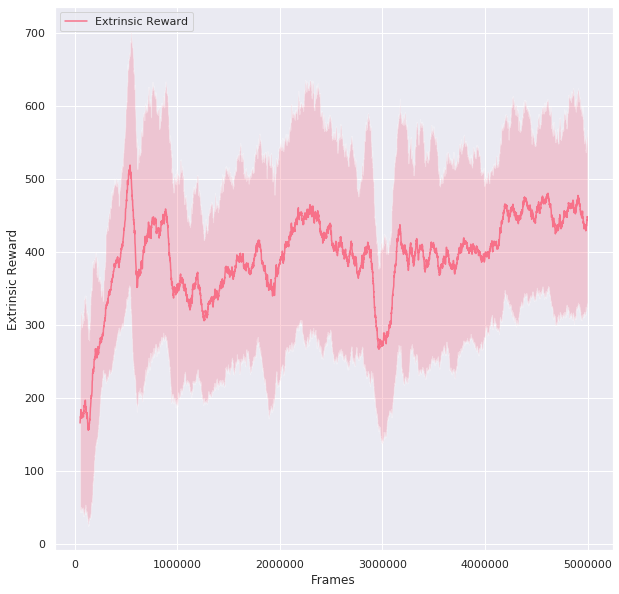

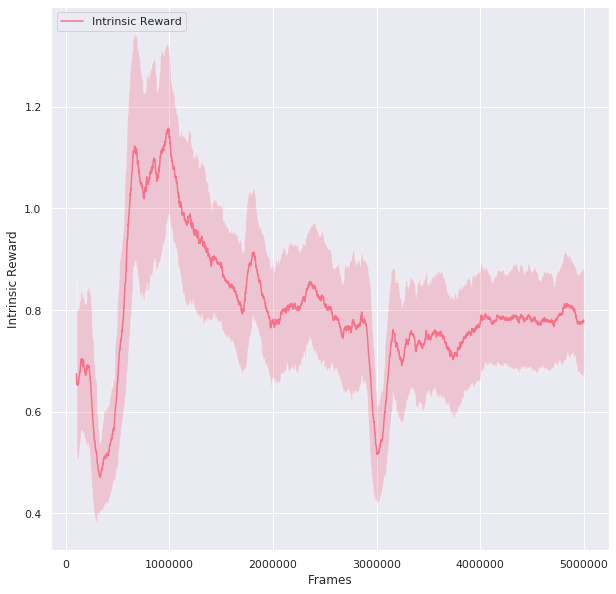

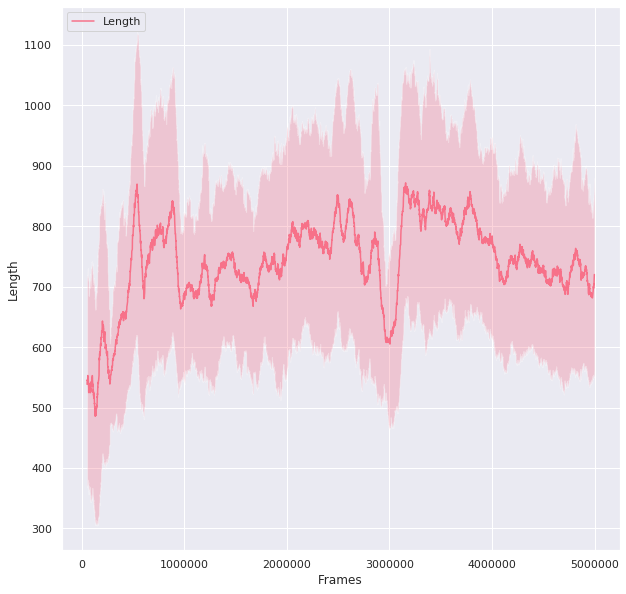

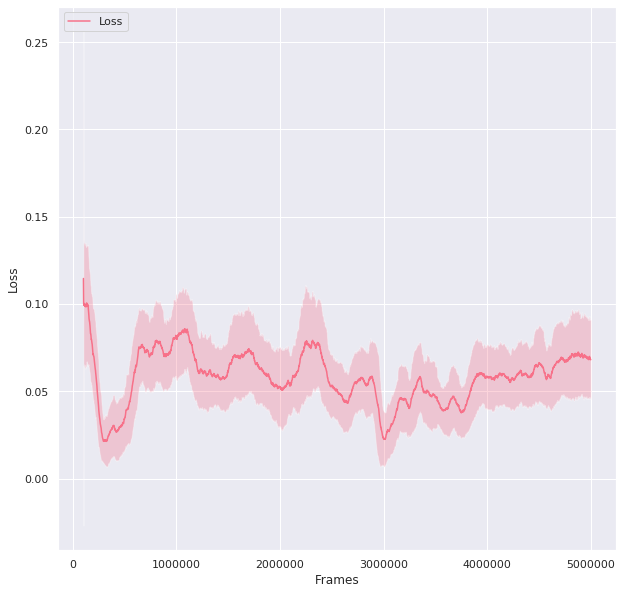

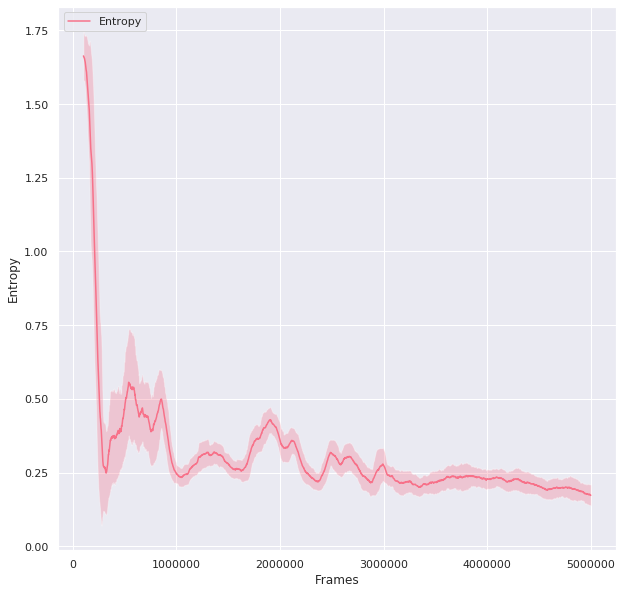

In [20]:
def plot_log(log, ylabel):
    # compute rolling avg and std
    df = pd.DataFrame(log, columns =['Frames', 'Iters', ylabel])
    sma_y = df[ylabel].rolling(100).mean()
    std_y = df[ylabel].rolling(100).std()
    
    # plot with seaborn
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Frames')
    ax.set_ylabel(ylabel)
    clrs = sns.color_palette("husl", 8)

    # fill standard deviation
    ax.plot(df['Frames'], sma_y, label=ylabel, c=clrs[0])
    ax.fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                    alpha=0.3, facecolor=clrs[0]) 
    ax.legend(loc='upper left')
    plt.savefig(SAVE_PATH+ENV_NAME+'.'+ylabel+'.plt.png', 
                dpi=300, pad_inches=0)
    plt.show()

plot_log(logger.log['ep_r'], 'Extrinsic Reward')
plot_log(logger.log['int'], 'Intrinsic Reward')
plot_log(logger.log['ep_l'], 'Length')
plot_log(logger.log['loss'], 'Loss')
plot_log(logger.log['ent'], 'Entropy')

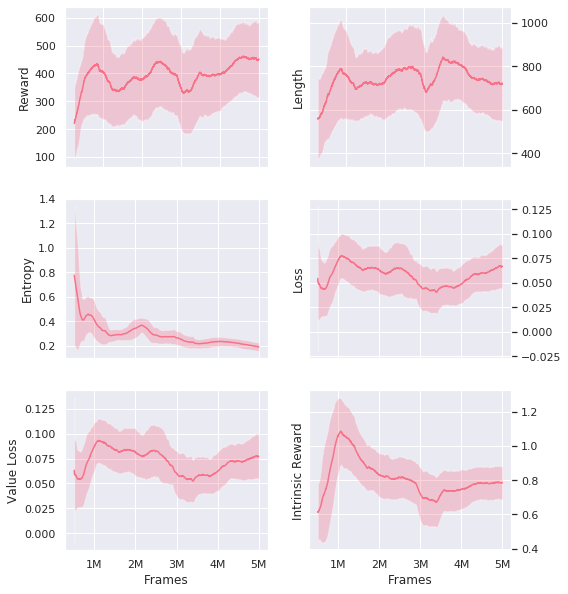

In [21]:
fig_all, ax_all = plt.subplots(3,2, figsize=(8,10))

## REWARD 
df = pd.DataFrame(logger.log['ep_r'], columns =['Frames', 'Iters', 'rwd'])
sma_y = df['rwd'].rolling(500).mean()
std_y = df['rwd'].rolling(500).std()

ax_all[0][0].set_ylabel('Reward')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[0][0].plot(df['Frames'], sma_y, label='Episode Reward', c=clrs[0])
ax_all[0][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
ax_all[0][0].set_xticklabels('')


## LENGTH 
df = pd.DataFrame(logger.log['ep_l'], columns =['Frames', 'Iters', 'Len'])
sma_y = df['Len'].rolling(500).mean()
std_y = df['Len'].rolling(500).std()

ax_all[0][1].set_ylabel('Length')
ax_all[0][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[0][1].plot(df['Frames'], sma_y, label='Episode Length', c=clrs[0])
ax_all[0][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
ax_all[0][1].set_xticklabels('')


## ENTROPY 
df = pd.DataFrame(logger.log['ent'], columns =['Frames', 'Iters', 'ent'])
sma_y = df['ent'].rolling(500).mean()
std_y = df['ent'].rolling(500).std()

ax_all[1][0].set_ylabel('Entropy')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[1][0].plot(df['Frames'], sma_y, label='Entropy', c=clrs[0])
ax_all[1][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[1][0].get_xticks()/1e6]
ax_all[1][0].set_xticklabels('')


## LOSS 
df = pd.DataFrame(logger.log['loss'], columns =['Frames', 'Iters', 'Loss'])
sma_y = df['Loss'].rolling(500).mean()
std_y = df['Loss'].rolling(500).std()

ax_all[1][1].set_ylabel('Loss')
ax_all[1][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[1][1].plot(df['Frames'], sma_y, label='Loss', c=clrs[0])
ax_all[1][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[1][1].get_xticks()/1e6]
ax_all[1][1].set_xticklabels('')


## V LOSS 
df = pd.DataFrame(logger.log['vloss'], columns =['Frames', 'Iters', 'Loss'])
sma_y = df['Loss'].rolling(500).mean()
std_y = df['Loss'].rolling(500).std()

ax_all[2][0].set_xlabel('Frames')
ax_all[2][0].set_ylabel('Value Loss')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[2][0].plot(df['Frames'], sma_y, label='V Loss', c=clrs[0])
ax_all[2][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[2][0].get_xticks()/1e6]
ax_all[2][0].set_xticklabels(xlabels)


## INTRINSIC REWARD
df = pd.DataFrame(logger.log['int'], columns =['Frames', 'Iters', 'Int'])
sma_y = df['Int'].rolling(500).mean()
std_y = df['Int'].rolling(500).std()

ax_all[2][1].set_xlabel('Frames')
ax_all[2][1].set_ylabel('Intrinsic Reward')
ax_all[2][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[2][1].plot(df['Frames'], sma_y, label='Intrinsic Reward', c=clrs[0])
ax_all[2][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[2][1].get_xticks()/1e6]
ax_all[2][1].set_xticklabels(xlabels)

plt.savefig(SAVE_PATH+ENV_NAME+'_plot_thesis.png', 
            dpi=300, pad_inches=0, bbox_inches = 'tight')

plt.show()